In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import random
import statsmodels.api as sm


# prophet by Facebook
from fbprophet import Prophet


# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Groceries_Sales_data.xlsx",parse_dates=[0])
df.head()

,Date,Sales
0,2018-02-01,21199.0
1,2018-02-02,10634.0
2,2018-02-03,7966.0
3,2018-02-04,1353.0
4,2018-02-05,9497.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    756 non-null    datetime64[ns]
 1   Sales   756 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.9 KB


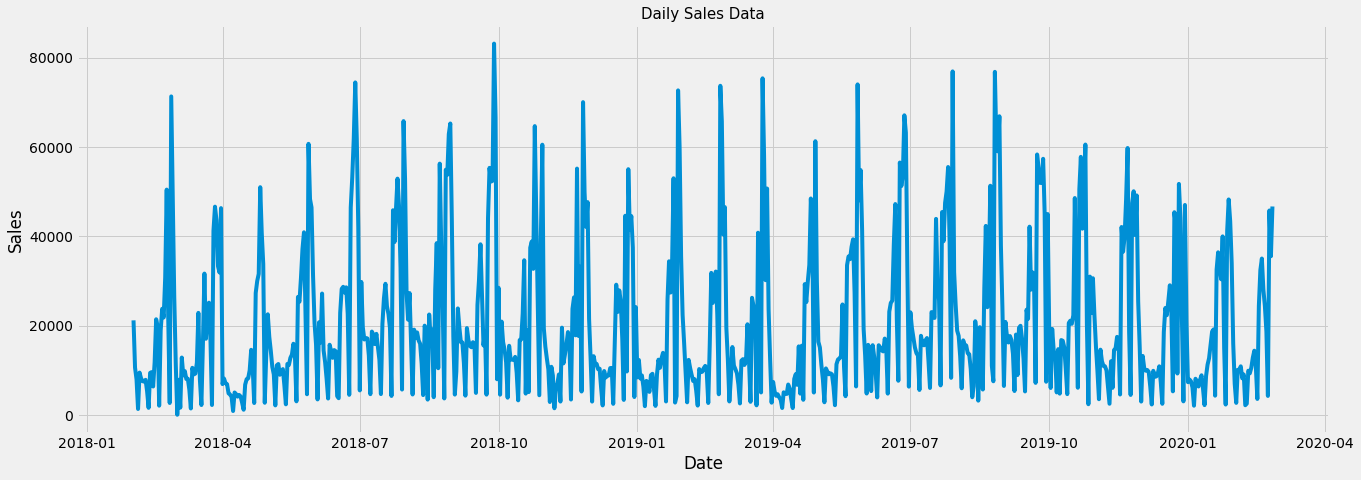

In [ ]:
## Plot the Time series data
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="Date", y="Sales", data=df)
a.set_title("Daily Sales Data",fontsize=15)
plt.show()

In [ ]:
def date_features(df, label=None):
    df = df.copy()

    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = date_features(df, label='Sales')
df_new = pd.concat([X, y], axis=1)
df_new.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Sales
0,Thursday,1,February,2018,32,1,5,21199.0
1,Friday,1,February,2018,33,2,5,10634.0
2,Saturday,1,February,2018,34,3,5,7966.0
3,Sunday,1,February,2018,35,4,5,1353.0
4,Monday,1,February,2018,36,5,6,9497.0


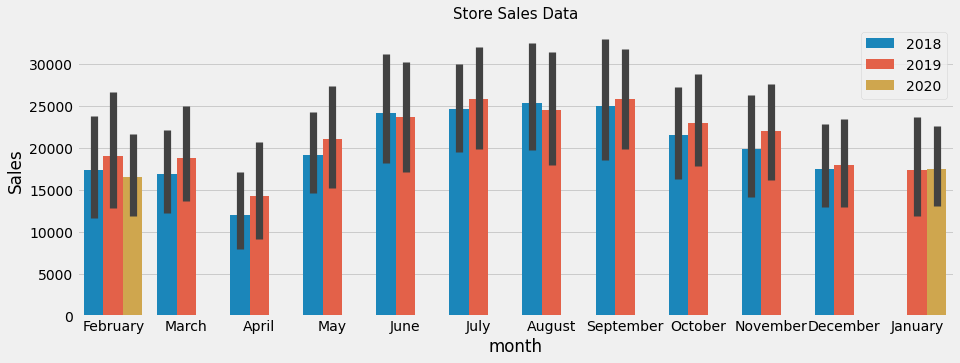

In [ ]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Sales",hue = 'year',data=df_new)
a.set_title("Store Sales Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Total Sales received By year')

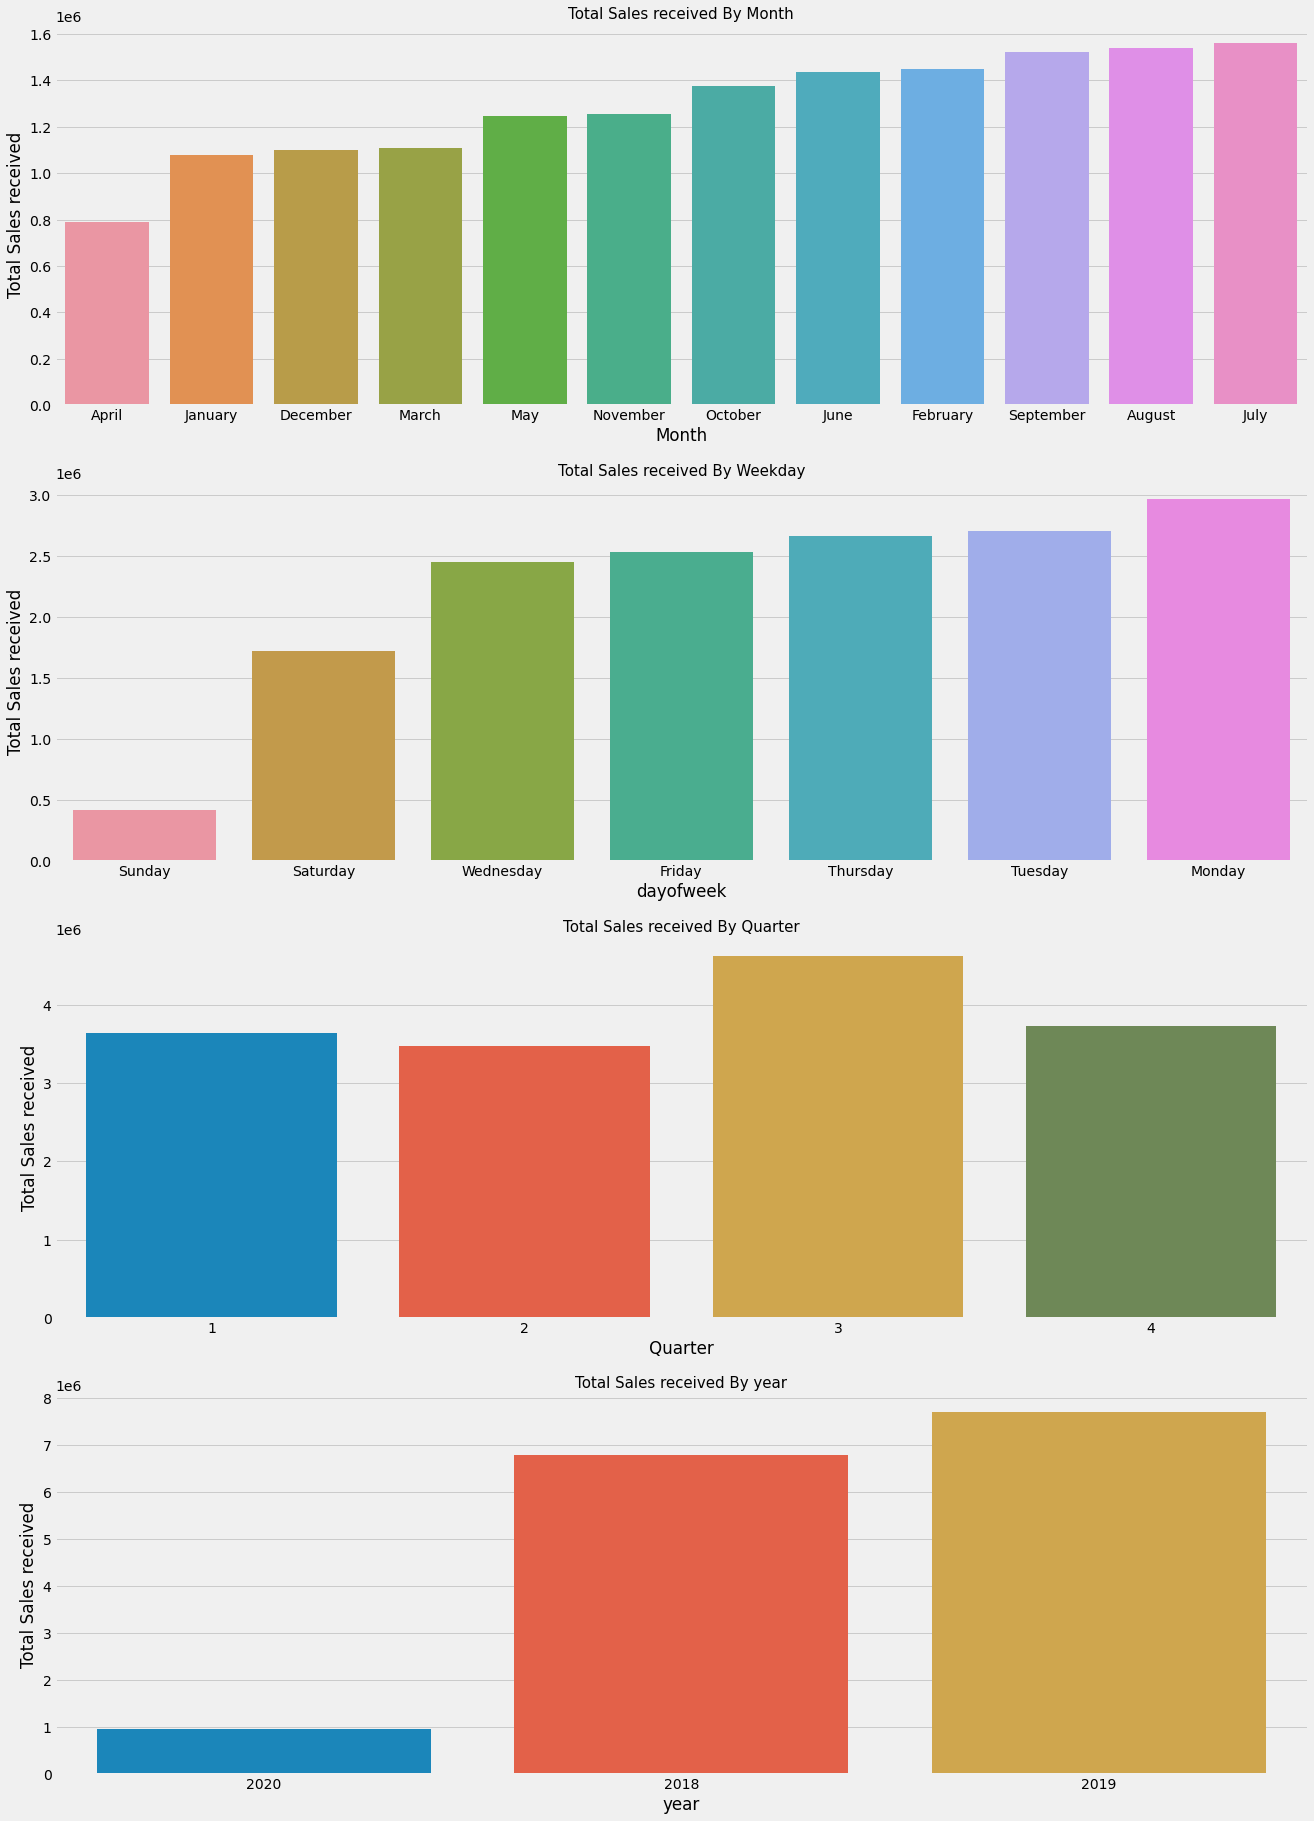

In [ ]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df_new.groupby("month")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="month",y="Sales",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Sales received')
ax1.set_title("Total Sales received By Month",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("dayofweek")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="dayofweek",y="Sales",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='Total Sales received')
ax2.set_title("Total Sales received By Weekday",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("quarter")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="quarter",y="Sales",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='Total Sales received')
ax3.set_title("Total Sales received By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("year")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="year",y="Sales",ax=ax4)
ax4.set(xlabel='year', ylabel='Total Sales received')
ax4.set_title("Total Sales received By year",fontsize=15)


In [ ]:
df=df.rename(columns={'Date':'ds','Sales':'y'})
df.head()

,ds,y
0,2018-02-01,21199.0
1,2018-02-02,10634.0
2,2018-02-03,7966.0
3,2018-02-04,1353.0
4,2018-02-05,9497.0


Dividing the dataset into train and test. The train has data from Feb,2018 to Dec,2019. Test Data has 2 months from Jan,2020 to Feb,2020.

In [ ]:
end_date = '2019-12-31'
mask1 = (df['ds'] <= end_date)
mask2 = (df['ds'] > end_date)

In [ ]:
X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (699, 2)
test shape (57, 2)


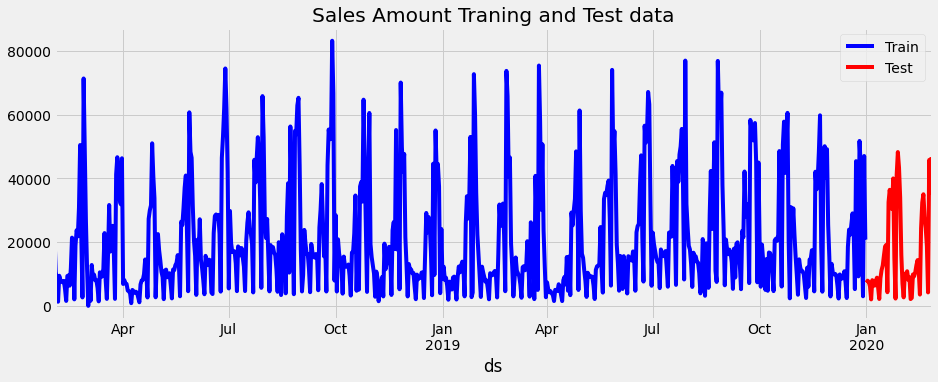

In [ ]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_tr.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_tst.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Sales Amount Traning and Test data')
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**Simple Prophet Model**

In [ ]:
model =Prophet()
model.fit(X_tr)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Now, we will predict by creating future dataframe next dates of train data. make_future_dataframe has include_history = True by default. So the predcition will be done for train data as well.

In [ ]:
future = model.make_future_dataframe(periods=57, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
749,2020-02-20,28012.544509,9473.516909,46046.684518
750,2020-02-21,26704.167287,7631.588882,45222.124715
751,2020-02-22,19174.217020,192.646157,38915.880165
752,2020-02-23,6772.169551,-12806.660418,25970.049108
753,2020-02-24,30627.914726,12177.640452,49465.448495
754,2020-02-25,27891.333496,9510.530750,47288.615967
755,2020-02-26,25493.248917,6449.913197,45737.105216


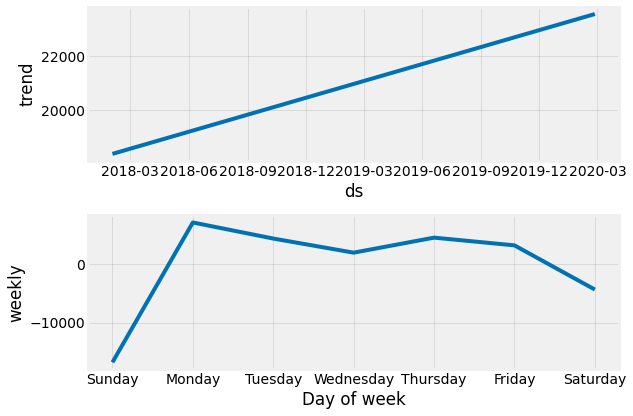

In [ ]:
# Plot the components of the model
fig = model.plot_components(forecast)

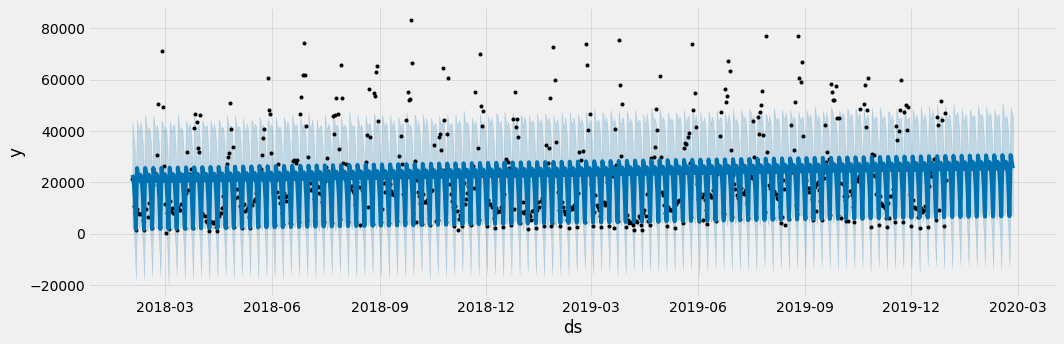

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

**Actual vs Prediction Comparison**

In [ ]:
X_tst_forecast = model.predict(X_tst)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
50,2020-02-20,28012.544509,7991.083551,46218.782968
51,2020-02-21,26704.167287,6728.112647,48747.348715
52,2020-02-22,19174.217020,-1086.608260,38368.772841
53,2020-02-23,6772.169551,-11260.318647,26818.278861
54,2020-02-24,30627.914726,11834.011320,50961.553071
55,2020-02-25,27891.333496,7822.677318,47909.146313
56,2020-02-26,25493.248917,5729.906967,45200.576568


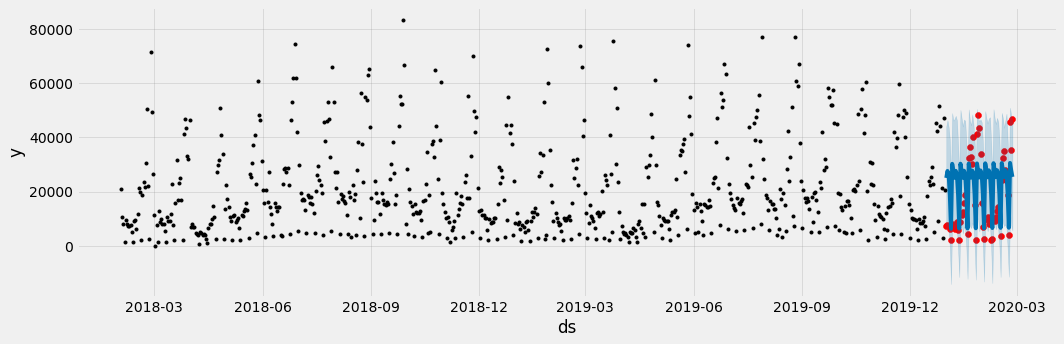

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

**Compare the test Sales and forecasted Sales**

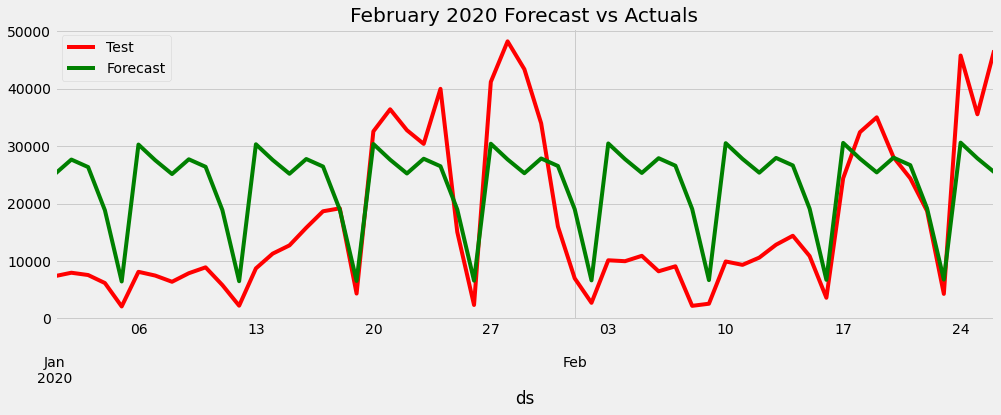

In [ ]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

We can see from the above plot, that there is huge gap in prediction. So we need to optimize the model by adding other parameters like holidays, changepoints etc.

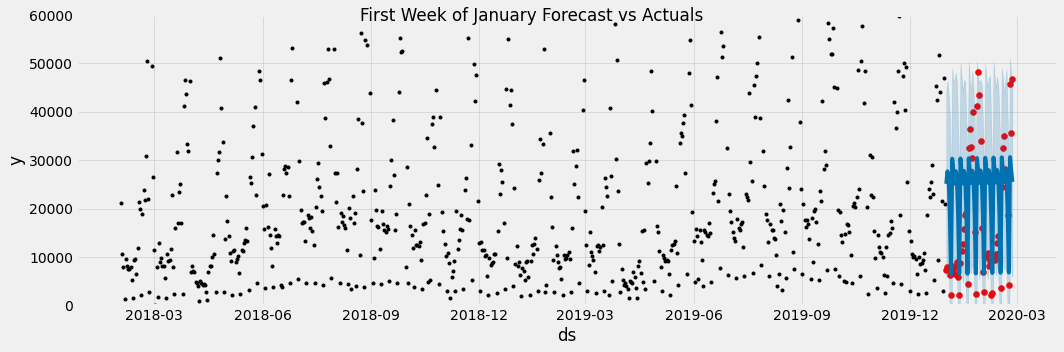

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)
# ax.set_xbound(lower='2020-01-01', upper='2020-01-08')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [ ]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 129.019


**Adding Holidays to the model**


We will use holidays library to get the US holidays

In [ ]:
import holidays

In [ ]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [ ]:
holiday.head()

,ds,holiday
0,2018-01-01,US-Holidays
1,2018-01-15,US-Holidays
2,2018-02-19,US-Holidays
3,2018-05-28,US-Holidays
4,2018-07-04,US-Holidays


In [ ]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(X_tr)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model_with_holidays.make_future_dataframe(periods=57, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
749,2020-02-20,28244.340719,9789.801691,47201.938767
750,2020-02-21,26893.888701,7917.797468,44061.013570
751,2020-02-22,19356.325407,689.123238,38040.512359
752,2020-02-23,6955.405933,-13254.069942,25149.780665
753,2020-02-24,30969.575192,10623.430479,48357.716275
754,2020-02-25,28108.375340,8699.915346,46272.205026
755,2020-02-26,25710.929127,7310.682862,46082.571878


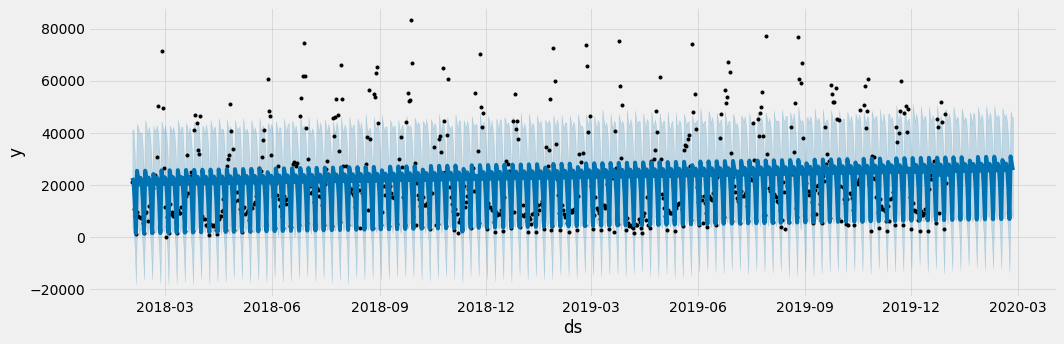

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

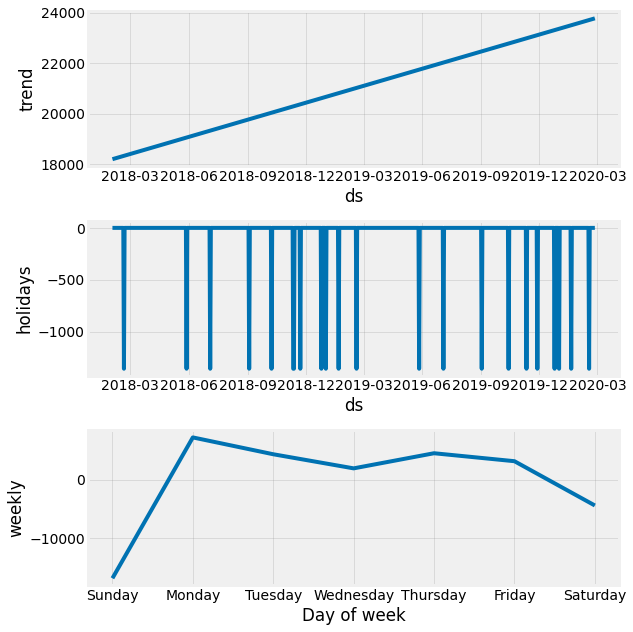

In [ ]:
# Plot the components of the model
fig = model_with_holidays.plot_components(forecast)

In [ ]:
X_tst_forecast_holiday = model_with_holidays.predict(X_tst)
X_tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
50,2020-02-20,28244.340719,6911.962850,47196.388365
51,2020-02-21,26893.888701,7491.952383,45599.317683
52,2020-02-22,19356.325407,1315.168353,37714.831043
53,2020-02-23,6955.405933,-13680.837597,26789.113037
54,2020-02-24,30969.575192,12219.392862,51551.868028
55,2020-02-25,28108.375340,9053.095587,48790.595953
56,2020-02-26,25710.929127,6122.148286,45348.252325


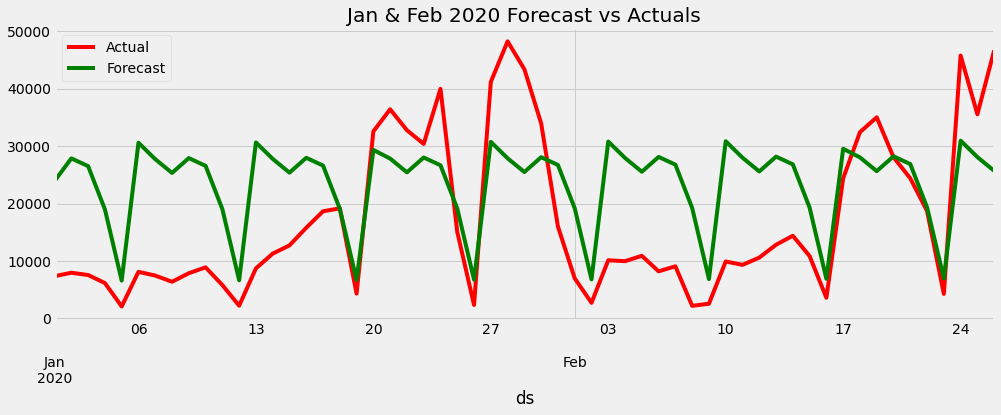

In [ ]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()


In [ ]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast_holiday['yhat'])
print("MAPE",round(mape,4))

MAPE 130.6784


**HyperParameter Tuning using ParameterGrid**

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


**Prophet Model Tuning**

In [ ]:
strt='2019-12-31'
end='2020-02-26'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(X_tr)
    train_forecast = train_model.make_future_dataframe(periods=57, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 104.81429109034168
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 105.29565550819358
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 104.39606893880651
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 105.66489438916544
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Erro

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,100.917903,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
1,101.691904,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
2,101.928474,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
3,102.009011,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
4,102.018117,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."


In [ ]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

In [ ]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(X_tr)

In [ ]:
future = final_model.make_future_dataframe(periods=122, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
814,2020-04-25,12211.132718,-15572.800569,40418.896069
815,2020-04-26,-1385.283257,-28737.925580,25206.408706
816,2020-04-27,26412.398689,-2282.376185,54013.370903
817,2020-04-28,23674.143552,-4371.335190,51578.197914
818,2020-04-29,21364.447819,-4650.849975,49676.773099
819,2020-04-30,24062.578595,-1328.489802,53002.502233
820,2020-05-01,23359.643785,-2653.615662,50700.681109


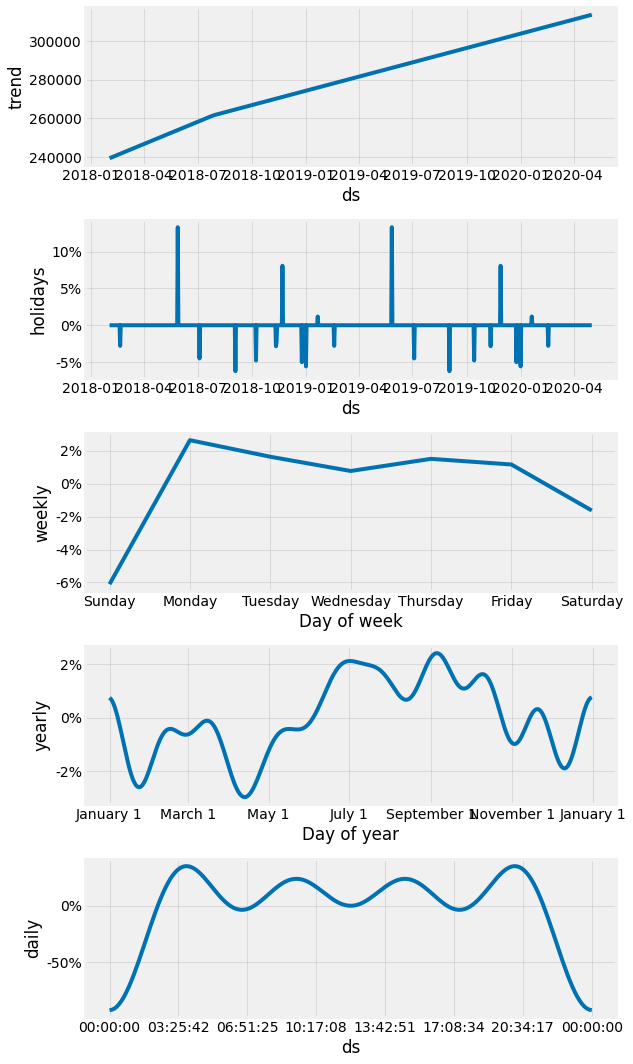

In [ ]:
# Plot the components of the model
fig = final_model.plot_components(forecast)

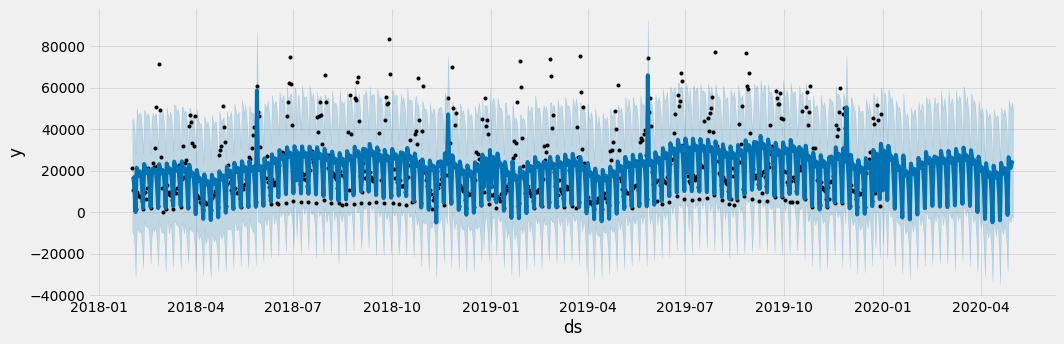

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [ ]:
X_tst_final= final_model.predict(X_tst)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
50,2020-02-20,26281.001776,-178.005075,54963.782466
51,2020-02-21,25150.491665,-2921.297122,53434.762428
52,2020-02-22,16461.829569,-12327.503092,44904.849555
53,2020-02-23,2594.481255,-24687.018772,30636.139592
54,2020-02-24,29456.165085,1491.573658,55999.220431
55,2020-02-25,26292.915108,-1834.060843,53926.504089
56,2020-02-26,23576.049673,-5522.030702,49389.326191


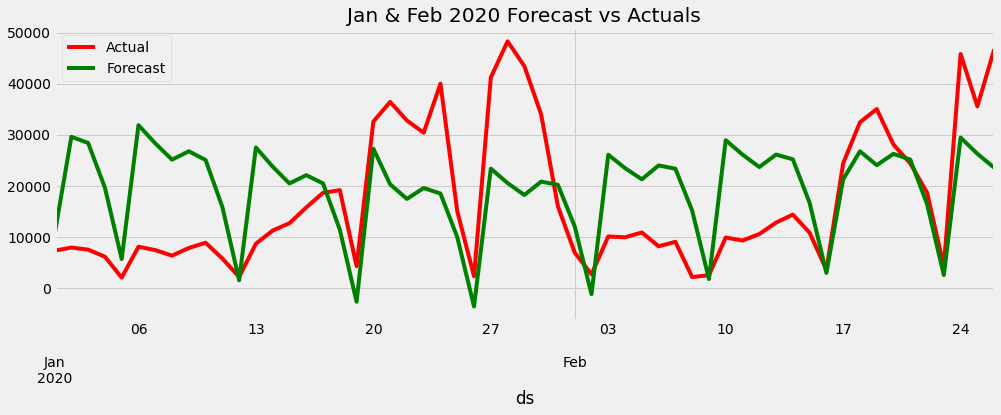

In [ ]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()

In [ ]:
MAPE = mean_absolute_percentage_error(X_tst['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

MAPE 104.67570107110127
